In [56]:
#required libraries
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_squeezenet import SqueezeNet
from keras_applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras
import unittest

ImportError: cannot import name '_obtain_input_shape' from 'keras.applications.imagenet_utils' (C:\Users\Sarmad Nazki\anaconda3\lib\site-packages\keras\applications\imagenet_utils.py)

In [53]:
#create a list in which we can add two values covid and non covid
data_train = []
type_of_disease =['COVID', 'non-COVID']
data_directory = r"C:\Users\Sarmad Nazki\Desktop\COVID-19 Dataset"
train_directory = os.path.join(data_directory)

for id, sp in enumerate(type_of_disease):
    print('************')
    print(id)
    print(sp)
    for file in os.listdir(os.path.join(train_directory )):
        print('************')
        print(file)
        
        data_train.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(data_train, columns=['Image', 'Id of Disease','Type of Disease'])


************
0
COVID
************
CT
************
desktop.ini
************
1
non-COVID
************
CT
************
desktop.ini


In [26]:
#check your dataframe which can be developed
train.head()
#Training model


,Image,Id of Disease,Type of Disease
0,COVID/CT,0,COVID
1,COVID/desktop.ini,0,COVID
2,non-COVID/CT,1,non-COVID
3,non-COVID/desktop.ini,1,non-COVID


In [27]:
#make the order of training set randomize
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))

In [28]:
train.head()

,Image,Id of Disease,Type of Disease
0,COVID/desktop.ini,0,COVID
1,non-COVID/desktop.ini,1,non-COVID
2,COVID/CT,0,COVID
3,non-COVID/CT,1,non-COVID


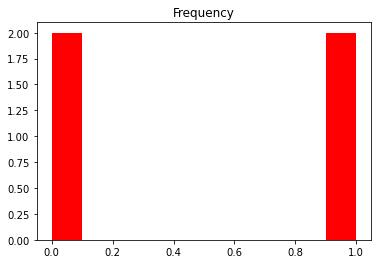

In [33]:
#checking with plot to understand the frequency of histogram 
plt.hist(train['Id of Disease'],color = "red")
plt.title('Frequency')
plt.show()


In [48]:
#creating a function which shows the images of the covid

#def show_covid_images(disease_type, r, c):
    #fig,ax = plt.subplots(r,c, figsize=(10,10))
    #disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    #n = 0
    #for i in range(r):
        #for j in range(c):
            #image = os.path.join(data_directory, disease_image[n])
            #ax[i, j].set_xticks([])
            #ax[i, j].set_yticks([])
            #ax[i, j].imshow(cv2.imread(image))
            #n += 1
            
#show_covid_images('COVID',4,4) 

In [ ]:
# creating a function which shows non-covid images
#def show_non_covid_images(disease_type, r, c):
    #fig,ax = plt.subplots(r,c, figsize=(10,10))
    #disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    #n = 0
    #for i in range(r):
        #for j in range(c):
            #image = os.path.join(data_directory, disease_image[n])
            #ax[i, j].set_xticks([])
            #ax[i, j].set_yticks([])
            #ax[i, j].imshow(cv2.imread(image))
            #n += 1
            
#show_non_covid_images('non-COVID',4,4)

In [ ]:
SIZE_OF_IMAGE = 64
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)     
                        
            

In [36]:
#training images

x_train = np.zeros((train.shape[0], SIZE_OF_IMAGE, SIZE_OF_IMAGE, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train[i] = resize_image(image,(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
        
X_Train = x_train / 255
print('Train shape: {}'.format(X_Train.shape))


4it [00:00, 4142.52it/s]

Train shape: (4, 64, 64, 3)


In [38]:
#conerting labels to Categorical
y_train = train['Id of Disease'].values
y_train = to_categorical(y_train, num_classes=2)

In [39]:
#train and tes splitting
BATCH_SIZE = 64

X_train, X_test, Y_train, Y_test = train_test_split(X_Train,y_train, test_size=0.2, random_state=SEED)


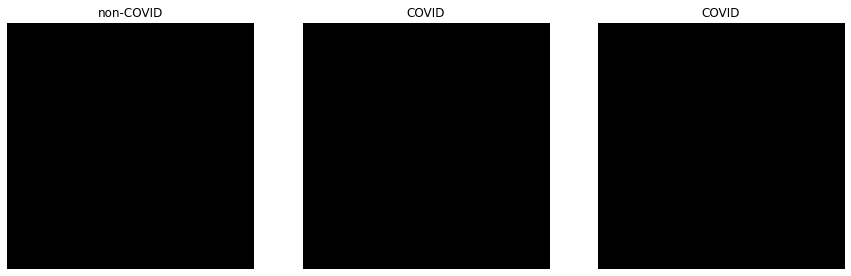

In [41]:
#training_images
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(type_of_disease[np.argmax(Y_train[i])])


In [42]:
EPOCHS = 50
SIZE=64
N_ch=3

In [49]:
#SqueezeNet 

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
